# Simulação de escalonamento

## Detecção de perfil

### Promonitor



In [ ]:
!wc /content/drive/MyDrive/ime/allan-matheus-mestrado/data/binclf.csv 

  109272   109272 12609499 /content/drive/MyDrive/ime/allan-matheus-mestrado/data/binclf.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ime/allan-matheus-mestrado/data/binclf.csv')

## ML

In [ ]:
hpl_cpu_clf_gte = joblib.load('/content/drive/MyDrive/ime/allan-matheus-mestrado/models/hpl_cpu_RFC.joblib')
hpl_cpu_clf_gt = joblib.load('/content/drive/MyDrive/ime/allan-matheus-mestrado/models/hpl_cpu_RFC-gt.joblib')

In [ ]:
windows = 3
resources = ['cpu', 'io_total']
target_resource = 'cpu'
features = ['%s-1' % r for r in resources]
features.extend(['%s-diff-%d' % (r, d)
    for r in resources
    for d in reversed(range(1, 1 + windows))])
target = '%s-up' % target_resource

In [ ]:
features

['cpu-1',
 'io_total-1',
 'cpu-diff-3',
 'cpu-diff-2',
 'cpu-diff-1',
 'io_total-diff-3',
 'io_total-diff-2',
 'io_total-diff-1']

In [ ]:
query = (df['application'] == 'hpl') & (df['task_id'] == '5de7281b9975b01756272e43')
X = df[query][features].values
y = df[query][target].values
X.shape, y.shape

((511, 8), (511,))

In [ ]:
ypred_gt = hpl_cpu_clf_gt.predict(X)
ypred_gt.shape

(511,)

In [ ]:
ypred_gte = hpl_cpu_clf_gte.predict(X)
ypred_gte.shape

(511,)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
('>', roc_auc_score(y, ypred_gt))

('>', 0.5128458498023716)

In [ ]:
('>=', roc_auc_score(y, ypred_gte))

array([0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
('>=', roc_auc_score(y, ypred_gte))

('>=', 1.0)

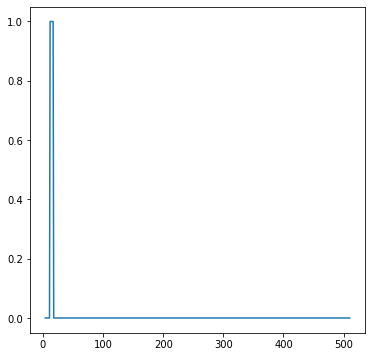

In [ ]:
(pd.Series(ypred_gt)
    .rolling(5)
    .apply(lambda x: (x > 0).all())
    .dropna()).plot(figsize=(6, 6))

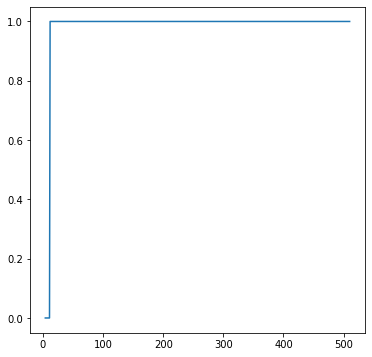

In [ ]:
(pd.Series(ypred_gte)
    .rolling(5)
    .apply(lambda x: (x > 0).all())
    .dropna()).plot(figsize=(6, 6))

In [ ]:
monitoring = pd.DataFrame({'cpu-1': X[:,0], 'ypred_gt': ypred_gt, 'ypred_gte': ypred_gte})

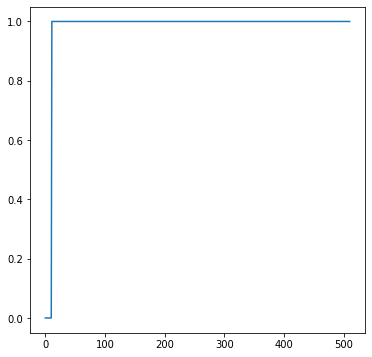

In [ ]:
((monitoring['cpu-1'] > 90)
            | ((monitoring['cpu-1'] > 70) & (monitoring['ypred_gt'] > 0))
).astype(int).plot(figsize=(6, 6))

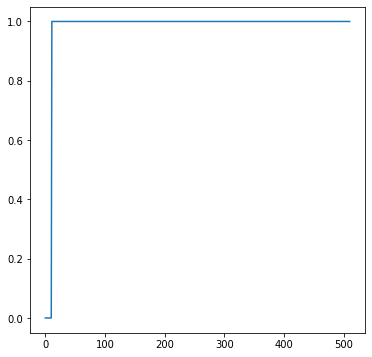

In [ ]:
((monitoring['cpu-1'] > 90)
            | ((monitoring['cpu-1'] > 70) & (monitoring['ypred_gt'] > 0))
).astype(int).plot(figsize=(6, 6))

## EMA

In [ ]:
# (oliveira2016) TAB. 6.2: Valores para identificação de perfil de tarefas
CONFIG = {
    'cpu': { 'threshold': 90, 'N': 5 },
    'io': { 'threshold': 20 * 1024**2, 'N': 25 }
}

In [ ]:
def ema_above_threshold(df, app, task, col, threshold, hold_on=5, N=10, plot=False):
    query = (df['application'] == app) & (df['task_id'] == task)
    ema = (df[query][col]
           .ewm(span=N)
            .mean())
    result = (ema
              .rolling(hold_on)
              .apply(lambda x: (x > threshold).all())
              .dropna())
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        df[query][col].plot(ax=ax[0])
        ema.plot(ax=ax[0])
        ax[0].axhline(y=threshold)
        result.plot(ax=ax[1])
        plt.show()
    return result

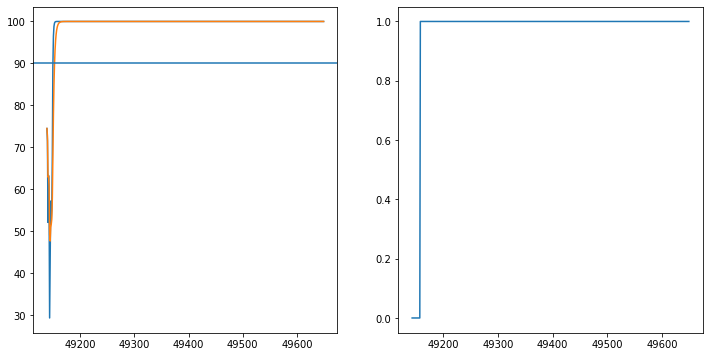

49143    0.0
49144    0.0
49145    0.0
49146    0.0
49147    0.0
        ... 
49645    1.0
49646    1.0
49647    1.0
49648    1.0
49649    1.0
Name: cpu-1, Length: 507, dtype: float64

In [ ]:
ema_above_threshold(df, app='hpl', task='5de7281b9975b01756272e43', col='cpu-1', plot=True, **CONFIG['cpu'])

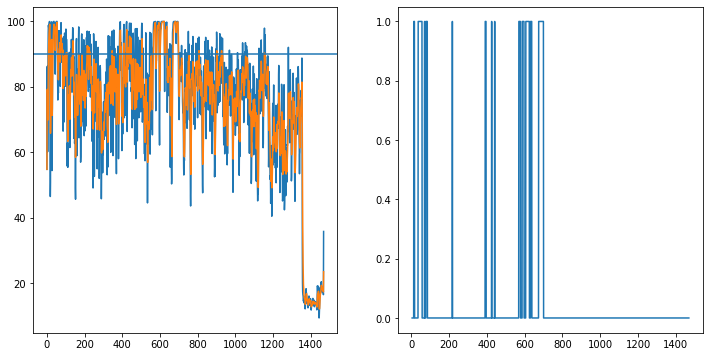

4       0.0
5       0.0
6       0.0
7       0.0
8       0.0
       ... 
1465    0.0
1466    0.0
1467    0.0
1468    0.0
1469    0.0
Name: cpu-1, Length: 1466, dtype: float64

In [ ]:
ema_above_threshold(df, app='blast', task='5de920271b1d9b333695177d', col='cpu-1', plot=True, **CONFIG['cpu'])

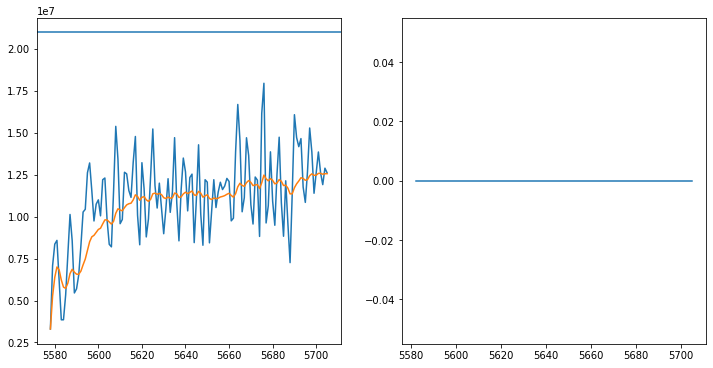

5582    0.0
5583    0.0
5584    0.0
5585    0.0
5586    0.0
       ... 
5701    0.0
5702    0.0
5703    0.0
5704    0.0
5705    0.0
Name: io_total-1, Length: 124, dtype: float64

In [ ]:
ema_above_threshold(df, app='montage', task='5deaa0101b1d9b33369517eb', col='io_total-1', plot=True, **CONFIG['io'])

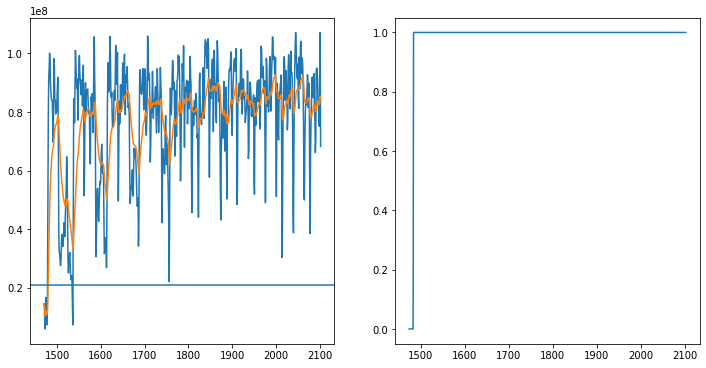

1474    0.0
1475    0.0
1476    0.0
1477    0.0
1478    0.0
       ... 
2098    1.0
2099    1.0
2100    1.0
2101    1.0
2102    1.0
Name: io_total-1, Length: 629, dtype: float64

In [ ]:
ema_above_threshold(df, app='iozone', task='5de9b6fb1b1d9b3336951793', col='io_total-1', plot=True, **CONFIG['io'])